# The Change in Average Length of Films Over Time

### Kelly Zabors | July 2nd | Digital Humanities 100 | Dr. Adam Anderson

In [1]:
#Importing additional features
import numpy as np
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv, solve
%matplotlib inline
sns.set()
sns.set_context("talk")

from IPython.display import display, Latex, Markdown
from sklearn.feature_extraction import DictVectorizer

### Step 1: Loading files into the Notebook and Structuring Dataset

#### Bringing the databases into the project

In [2]:
fivek_movies = pd.read_csv('movie_metadata.csv')
twok_movies = pd.read_csv('movie_database.csv')

internet = pd.read_csv('broadband-penetration-by-country.csv')
socialmedia = pd.read_csv('users-by-social-media-platform.csv')
technology = pd.read_csv('technology-adoption-by-households-in-the-united-states.csv')

#### Filtering data to just US films in English, then removing unnecessary columns and creating an editable copy.                                  This way I can make edits on the copy without losing any information from the original

In [3]:
fivek_movies = fivek_movies.where(fivek_movies['country']=='USA').where(fivek_movies['language']=='English').dropna()
fivek_movies = fivek_movies.drop(['country', 'language'], axis=1)
movies = fivek_movies

#### Filtering internet subscriptions to US only, and then removing the country columns

In [4]:
internet = internet.where(internet['Code']=='USA').dropna()
internet = internet.drop(['Entity','Code'],axis=1)
internet = internet.rename(columns={'Fixed broadband subscriptions (per 100 people) (per 100 people)':'% of Population Subscribed'})

#### Removing NaN column from technology dataset, renaming columns

In [5]:
technology = technology.drop(['Code'],axis=1)
technology = technology.rename(columns={'Technology Diffusion (Comin and Hobijn (2004) and others) (%)':
                                       'Percent Used', 'Entity':'Tech'})

#### Splitting the technology dataset into DataFrames based off individual technologies

In [6]:
social = technology.where(technology['Tech']=='Social media usage')
computer = technology.where(technology['Tech']=='Computer')
phone = technology.where(technology['Tech']=='Smartphone usage')
tablet = technology.where(technology['Tech']=='Tablet')
internet_use = technology.where(technology['Tech']=='Internet')

#### Removing NaN column from socialmedia dataset

In [7]:
socialmedia = socialmedia.drop(['Code'],axis=1)
socialmedia = socialmedia.rename(columns={'Monthly active users (Statista and TNW (2019)) (MAU)':'Monthly Users',
                            'Entity':'Platform'})

### Step 2: Working with DataFrames, Exploratory Data Analysis and Visualizations

#### Information on data per category

In [8]:
fivek_movies.describe()

num_critic_for_reviews     duration  director_facebook_likes  \
count             2973.000000  2973.000000              2973.000000   
mean               166.567777   109.682139               922.169526   
std                124.652585    22.144960              3354.750502   
min                  2.000000    37.000000                 0.000000   
25%                 76.000000    95.000000                12.000000   
50%                137.000000   106.000000                65.000000   
75%                223.000000   119.000000               243.000000   
max                813.000000   330.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             2973.000000             2973.000000  2.973000e+03   
mean               849.313824             8356.323579  5.885097e+07   
std               2020.775102            16830.564446  7.319522e+07   
min                  0.000000                0.000000  7.030000e+02   
25%                237.000000              826.000000  1.287057e+07   
50%                477.000000             2000.000000  3.514333e+07   
75%                726.000000            13000.000000  7.581799e+07   
max              23000.000000           640000.000000  7.605058e+08   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     2.973000e+03                2973.000000           2973.000000   
mean      1.104404e+05               12516.531450              1.418433   
std       1.589322e+05               20568.366254              2.131248   
min       9.100000e+01                   0.000000              0.000000   
25%       2.068800e+04                2282.000000              0.000000   
50%       5.633800e+04                4671.000000              1.000000   
75%       1.360190e+05               17040.000000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews        budget   title_year  \
count           2973.000000  2.973000e+03  2973.000000   
mean             340.973091  4.105004e+07  2002.937101   
std              410.706789  4.393255e+07     9.846351   
min                4.000000  2.180000e+02  1929.000000   
25%              112.000000  1.200000e+07  1999.000000   
50%              211.000000  2.600000e+07  2004.000000   
75%              406.000000  5.500000e+07  2010.000000   
max             4667.000000  3.000000e+08  2016.000000   

       actor_2_facebook_likes   imdb_score  aspect_ratio  movie_facebook_likes  
count             2973.000000  2973.000000   2973.000000           2973.000000  
mean              2217.287252     6.387084      2.101211           9493.359906  
std               4852.419115     1.051072      0.372663          21860.703852  
min                  0.000000     1.600000      1.180000              0.000000  
25%                448.000000     5.800000      1.850000              0.000000  
50%                742.000000     6.500000      2.350000            261.000000  
75%               1000.000000     7.100000      2.350000          11000.000000  
max             137000.000000     9.300000     16.000000         349000.000000

#### Plotting the average duration of films over the years

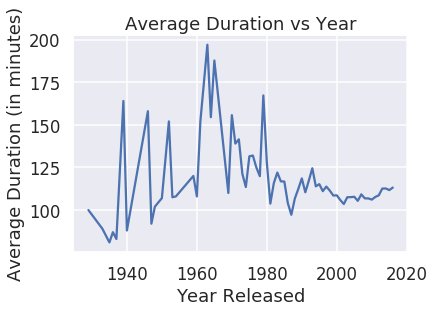

In [9]:
fivek_movies.groupby('title_year')['duration'].mean().plot()
plt.title('Average Duration vs Year')
plt.xlabel('Year Released')
plt.ylabel('Average Duration (in minutes)')
plt.show()

#### Plot of every film's duration vs year released, with yearly average duration overlayed

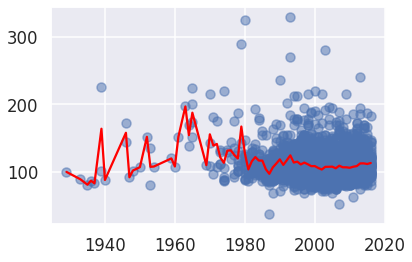

In [10]:
year_and_len = fivek_movies[['title_year','duration']]
scx1 = year_and_len['title_year']
scy1 = year_and_len['duration']
avg_scatter = year_and_len.groupby('title_year',as_index=False).mean()
scx2 = avg_scatter['title_year']
scy2 = avg_scatter['duration']
plt.scatter(scx1,scy1,alpha=.5)
plt.plot(scx2,scy2,c='red')

#### Plot of every film's duration vs year released with the average overlayed from 1990-2016

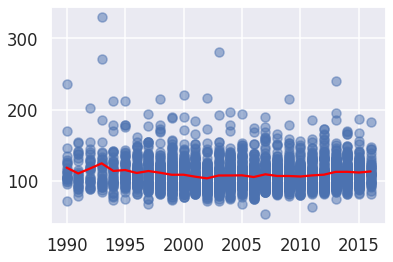

In [11]:
ninties_on = year_and_len.where(year_and_len['title_year']>=1990).dropna()
x1 = ninties_on['title_year']
y1 = ninties_on['duration']
plt.scatter(x1,y1, alpha=.5)
average = ninties_on.groupby('title_year', as_index=False).mean()
x2=average['title_year']
y2 = average['duration']
plt.plot(x2,y2,c='red')

#### Splitting average movie duration into smaller plots by 2 to 3 decades

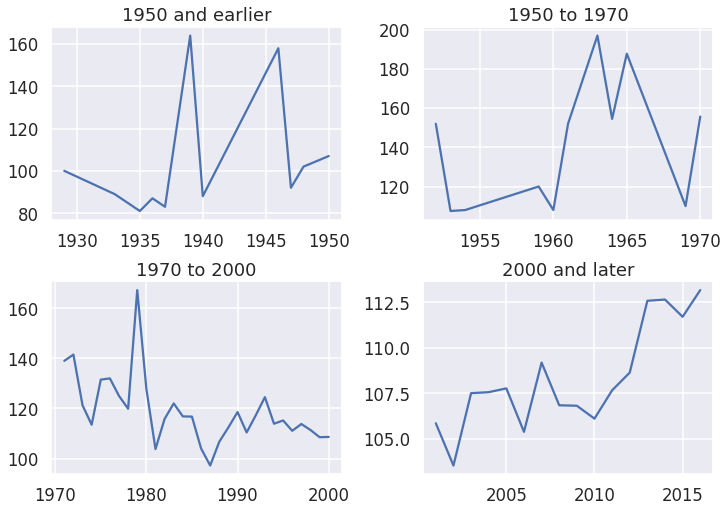

In [13]:
movie_specifics = movies[['duration', 'genres', 'movie_title', 'title_year', 'imdb_score']]
year_and_len = movie_specifics[['title_year','duration']]

fig, ax = plt.subplots(2,2,constrained_layout=True,figsize=(10,7))

below_fifty = year_and_len.where(year_and_len['title_year']<=1950).dropna()
b_f = below_fifty.groupby('title_year', as_index=False).mean()
ax[0,0].plot(b_f['title_year'],b_f['duration'])
ax[0,0].set_title('1950 and earlier')

fifty_seventy = year_and_len.where(year_and_len['title_year']>1950).where(year_and_len['title_year']<=1970).dropna()
f_s = fifty_seventy.groupby('title_year', as_index=False).mean()
ax[0,1].plot(f_s['title_year'],f_s['duration'])
ax[0,1].set_title('1950 to 1970')

seventy_zero = year_and_len.where(year_and_len['title_year']>1970).where(year_and_len['title_year']<=2000).dropna()
s_z = seventy_zero.groupby('title_year', as_index=False).mean()
ax[1,0].plot(s_z['title_year'],s_z['duration'])
ax[1,0].set_title('1970 to 2000')

zero_now = year_and_len.where(year_and_len['title_year']>2000).dropna().groupby('title_year', as_index=False).mean()
z_n = zero_now.groupby('title_year', as_index=False).mean()
ax[1,1].plot(z_n['title_year'],z_n['duration'])
ax[1,1].set_title('2000 and later')

plt.show()

#### Finding the mean and +/- one standard deviation of the films

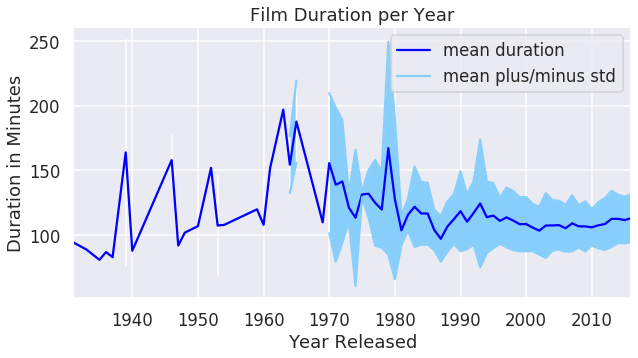

In [14]:
statistics = year_and_len['duration'].groupby(year_and_len['title_year']).describe()
yearly_runtime = statistics['mean']
lower_std = statistics['mean'] - statistics['std']
higher_std = statistics['mean'] + statistics['std']

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(yearly_runtime, color="blue", label='mean duration')
ax1.plot(lower_std, color="lightskyblue")
ax1.fill_between(yearly_runtime.index, lower_std, higher_std, facecolor='lightskyblue')
ax1.plot(higher_std, color="lightskyblue", label='mean plus/minus std')
ax1.set_title('Film Duration per Year')
ax1.set_ylabel('Duration in Minutes')
ax1.set_xlabel('Year Released')
ax1.set_xlim(1931, 2016)
ax1.legend()

plt.show()

#### Finding the mean and the interquartile range of the films

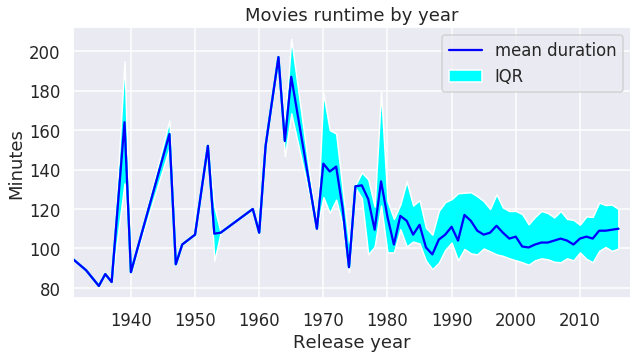

In [15]:
yearly_duration_average = statistics['50%']
lower_average = statistics['25%']
higher_average = statistics['75%']

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.fill_between(statistics.index, lower_average, higher_average, facecolor='aqua', label='IQR')
ax1.plot(yearly_duration_average, color="aqua")
ax1.plot(yearly_duration_average, color="aqua")
ax1.plot(yearly_duration_average, color="blue", label='mean duration')
ax1.set_title('Movies runtime by year')
ax1.set_ylabel('Minutes')
ax1.set_xlabel('Release year')
ax1.set_xlim(1931, 2018)

ax1.legend()
plt.show()

#### Grouping films by decade and comparing their duration ranges

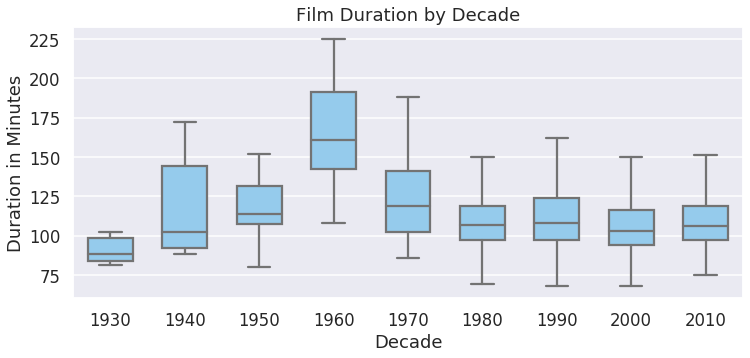

In [16]:
movies_by_decades = year_and_len.where(year_and_len['title_year']>=1930).dropna()
movies_by_decades['title_year'] = ((movies_by_decades['title_year'] // 10) * 10)
movies_by_decades['title_year'] = [int(x) for x in movies_by_decades['title_year']]

plt.figure(figsize=(12,5))

sns.boxplot(x="title_year", y="duration", data=movies_by_decades, color='lightskyblue',showfliers=False,width=.6)
plt.title('Film Duration by Decade')
plt.xlabel('Decade')
plt.ylabel('Duration in Minutes')
plt.show()

#### Grouping films by their durations and counting the amount of films per group

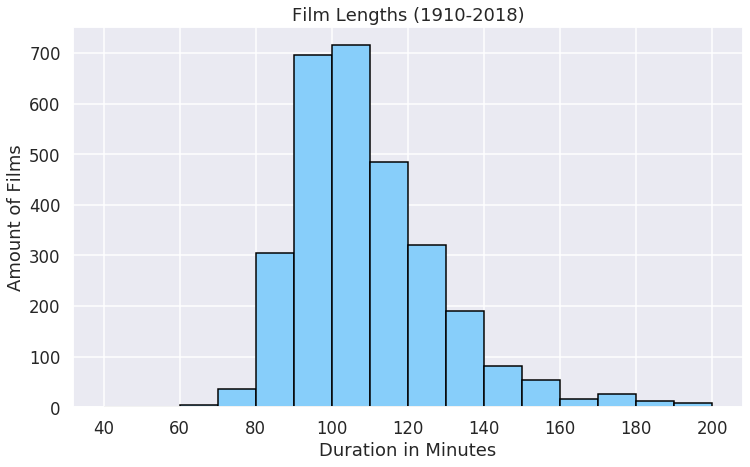

In [17]:
plt.figure(figsize=(12,7))

plt.hist(year_and_len['duration'], range=(40, 200), bins=16, ec='black',color='lightskyblue')
plt.title('Film Lengths (1910-2018)')
plt.xlabel('Duration in Minutes')
plt.ylabel('Amount of Films')
plt.show()

#### Filtering the Oscar datset to find the titles of the Best Film award winners– the award title changed four times;  four filters to accomodate

In [18]:
oscars = pd.read_csv('oscars_data.csv')
winners = oscars.where(oscars['winner']==True).dropna()
best = oscars.where(oscars['year']>=1962.0).where(oscars['category'] == 'BEST PICTURE').dropna()
outstanding = winners.where(winners['year']<1962).where(winners['category']=='OUTSTANDING PICTURE').dropna()
outstand = winners.where(winners['year']<1962).where(winners['category']=='OUTSTANDING PRODUCTION').dropna()
directing = winners.where(winners['category']=='DIRECTING').dropna()
winners.where(winners['year']<1962).dropna().where(winners['year']>=1960).dropna()
motion = winners.where(winners['category']=='BEST MOTION PICTURE').dropna()

#### Finding the titles of the Oscar winners– some are production companies, but will be excluded from the final data

In [19]:
first=list(outstanding['entity'])
second=list(outstand['entity'])
third=list(motion['entity'])
fourth=list(best['entity'])
winner_title = first+second+third+fourth
winner_title

['Paramount Famous Lasky',
 'Metro-Goldwyn-Mayer',
 'All Quiet on the Western Front',
 'Cimarron',
 'Grand Hotel',
 'Cavalcade',
 'It Happened One Night',
 'Mutiny on the Bounty',
 'The Great Ziegfeld',
 'The Life of Emile Zola',
 "You Can't Take It with You",
 'Gone with the Wind',
 'Rebecca',
 'Going My Way',
 'The Lost Weekend',
 'The Best Years of Our Lives',
 "Gentleman's Agreement",
 'Hamlet',
 "All the King's Men",
 'All about Eve',
 'An American in Paris',
 'The Greatest Show on Earth',
 'From Here to Eternity',
 'On the Waterfront',
 'Marty',
 'Around the World in 80 Days',
 'The Bridge on the River Kwai',
 'Gigi',
 'Ben-Hur',
 'The Apartment',
 'West Side Story',
 'Lawrence of Arabia',
 'The Longest Day',
 "Meredith Willson's The Music Man",
 'Mutiny on the Bounty',
 'To Kill a Mockingbird',
 'America America',
 'Cleopatra',
 'How the West Was Won',
 'Lilies of the Field',
 'Tom Jones',
 'Becket',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
 'Mary

#### Creating a scatter plot of all the Oscar winners' release year vs duration by finding the titles in the large film dataset

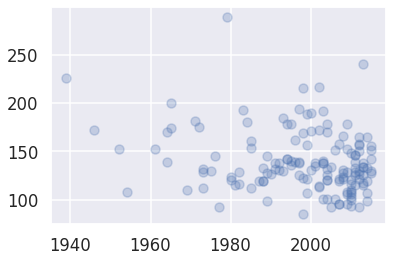

In [20]:
copy = fivek_movies
fivek_movies['Title'] = [x.replace(u'\xa0','') for x in fivek_movies['movie_title']]
find_win = [x in winner_title for x in fivek_movies['Title']]
fivek_movies['Oscars'] = find_win
oscar_wins = fivek_movies.where(fivek_movies["Oscars"]==True).dropna()
plt.scatter(oscar_wins['title_year'],oscar_wins['duration'], alpha=.25)

#### Average Oscar winning film duration on top of plot of all the Oscar winning films' release year vs durations

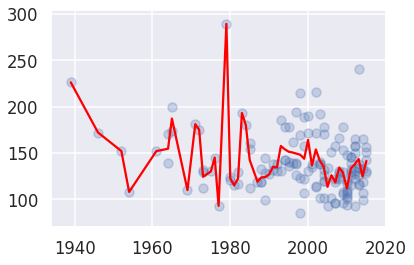

In [21]:
avg_oscar = oscar_wins.groupby(oscar_wins['title_year'],as_index=False).mean()
plt.plot(avg_oscar['title_year'], avg_oscar['duration'],c='red')
plt.scatter(oscar_wins['title_year'],oscar_wins['duration'], alpha=.25)

#### Comparing the Oscar winner films' average durations with the overall durations through two line plots

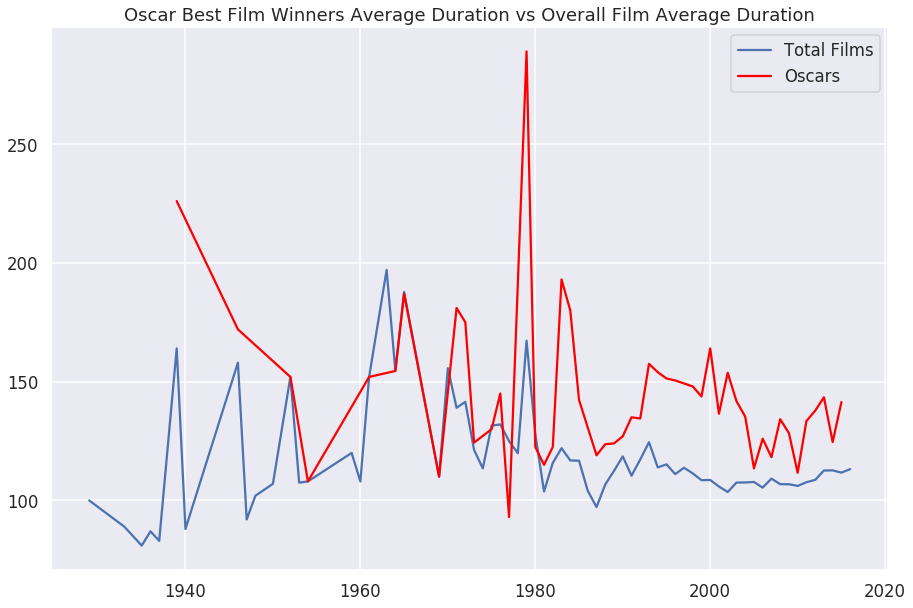

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 10))

fkmean = fivek_movies.groupby('title_year',as_index=False)['duration'].mean()
plt.plot(fkmean['title_year'],fkmean['duration'],label="Total Films")
plt.plot(avg_oscar['title_year'], avg_oscar['duration'],c='red',label="Oscars")
plt.legend()
plt.title('Oscar Best Film Winners Average Duration vs Overall Film Average Duration')
plt.show()

#### The Oscar winners are slightly longer than the average movie, but only from ~1980 onward

#### Finding the yearly average duration for both oscar winning and overall films from 1980 on, and then finding the difference between the two

In [23]:
oscar_duration = [int(x) for x in oscar_wins.where(oscar_wins['title_year']>=1980).groupby('title_year').mean()['duration'].dropna()]
total_duration = [int(x) for x in fivek_movies.where(fivek_movies['title_year']>=1980).groupby('title_year').mean()['duration'].dropna()]
np.mean(oscar_duration) - np.mean(total_duration)

27.316602316602314

#### The Oscar winners are slightly longer than the rest, however it's not statistically significant enough to be confident

#### Next topic: looking into film genres

#### Assigning films to individual genres based on the first genre listed

In [24]:
first_genre = list([i.split(r'|')[0] for i in movies['genres']])
movies['genre']=first_genre

#### Data sorted by genre and year, with the average duration per year per genre listed

In [25]:
genre_sort = movies.groupby(['genre', 'title_year'],as_index=False).mean()
genre_sort.head()

genre  title_year  num_critic_for_reviews    duration  \
0  Action      1963.0               61.000000  197.000000   
1  Action      1976.0              112.000000  119.000000   
2  Action      1977.0              282.000000  125.000000   
3  Action      1978.0              169.000000  188.000000   
4  Action      1980.0              156.333333  130.333333   

   director_facebook_likes  actor_3_facebook_likes  actor_1_facebook_likes  \
0               176.000000              760.000000              924.000000   
1                23.000000              440.000000             1000.000000   
2                 0.000000              504.000000            11000.000000   
3               503.000000              467.000000            10000.000000   
4               523.666667              395.666667             4197.666667   

         gross  num_voted_users  cast_total_facebook_likes  \
0   46300000.0     29323.000000                     4109.0   
1   25000000.0     39847.000000                     2951.0   
2  460935665.0    911097.000000                    13485.0   
3  134218018.0    126357.000000                    12940.0   
4  150852917.0    352179.333333                     6039.0   

   facenumber_in_poster  num_user_for_reviews      budget  \
0              0.000000                 344.0   9400000.0   
1              1.000000                 242.0   9000000.0   
2              1.000000                1470.0  11000000.0   
3              0.000000                 497.0  55000000.0   
4              1.666667                 496.0  33000000.0   

   actor_2_facebook_likes  imdb_score  aspect_ratio  movie_facebook_likes  \
0              898.000000    7.600000      2.760000              0.000000   
1              659.000000    6.800000      2.350000              0.000000   
2             1000.000000    8.700000      2.350000          33000.000000   
3              593.000000    7.300000      2.350000              0.000000   
4              593.333333    7.833333      2.183333          10333.333333   

   Oscars  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

#### Hard coding every genre into its own respective table through the above sorted table

In [26]:
Action = genre_sort.where(genre_sort['genre']=='Action').dropna()
Adventure = genre_sort.where(genre_sort['genre']=='Adventure').dropna()
Animation = genre_sort.where(genre_sort['genre']=='Animation').dropna()
Adventure = genre_sort.where(genre_sort['genre']=='Adventure').dropna()
Biography = genre_sort.where(genre_sort['genre']=='Biography').dropna()
Comedy = genre_sort.where(genre_sort['genre']=='Comedy').dropna()
Crime = genre_sort.where(genre_sort['genre']=='Crime').dropna()
Drama = genre_sort.where(genre_sort['genre']=='Drama').dropna()
Family = genre_sort.where(genre_sort['genre']=='Family').dropna()
Fantasy = genre_sort.where(genre_sort['genre']=='Fantasy').dropna()
Horror = genre_sort.where(genre_sort['genre']=='Horror').dropna()
Musical = genre_sort.where(genre_sort['genre']=='Musical').dropna()
Mystery = genre_sort.where(genre_sort['genre']=='Mystery').dropna()
Romance = genre_sort.where(genre_sort['genre']=='Romance').dropna()
SciFi = genre_sort.where(genre_sort['genre']=='Sci-Fi').dropna()
Horror = genre_sort.where(genre_sort['genre']=='Horror').dropna()
Thriller = genre_sort.where(genre_sort['genre']=='Thriller').dropna()
Western = genre_sort.where(genre_sort['genre']=='Western').dropna()

#### Graphing the genres by Year Released and Average Duration (Each data point is a yearly average duration)

##### (Family, Western, Thriller, and Musical all have <= 3 entries, so I placed them on the same graph)

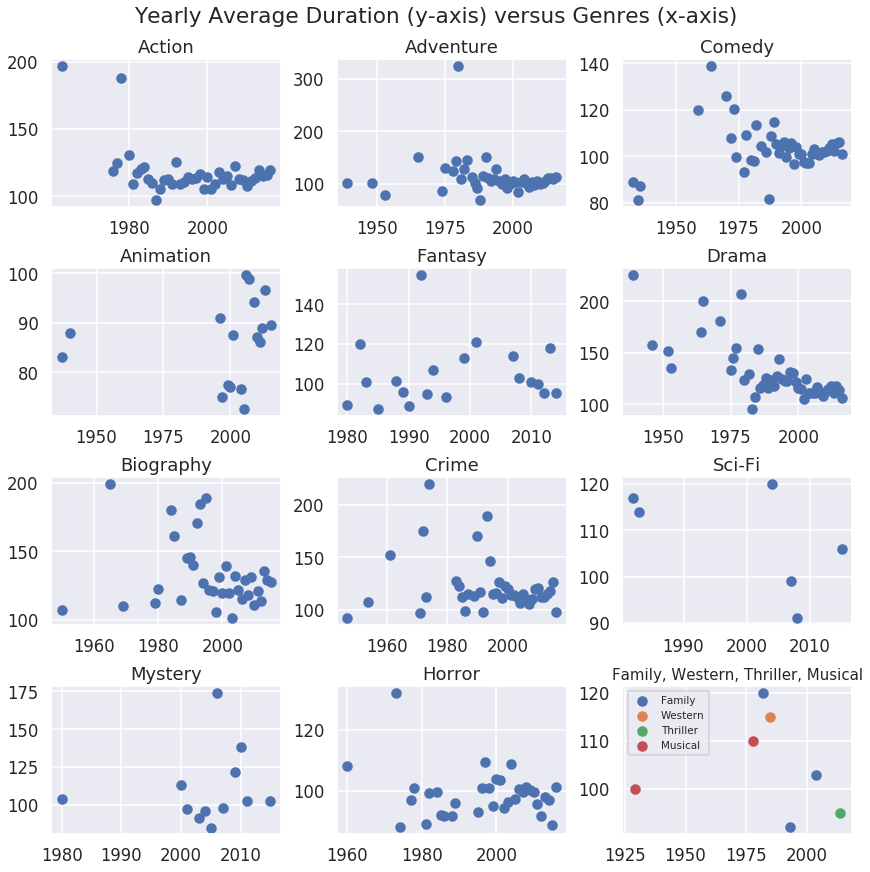

In [27]:
fig, ax = plt.subplots(4,3,constrained_layout=True,figsize=(12,12))

ax[0,0].scatter(Action['title_year'],Action['duration'])
ax[0,0].set_title('Action')

ax[0,1].scatter(Adventure['title_year'],Adventure['duration'])
ax[0,1].set_title('Adventure')

ax[1,0].scatter(Animation['title_year'],Animation['duration'])
ax[1,0].set_title('Animation')

ax[2,0].scatter(Biography['title_year'], Biography['duration'])
ax[2,0].set_title('Biography')

ax[0,2].scatter(Comedy['title_year'],Comedy['duration'])
ax[0,2].set_title('Comedy')

ax[2,1].scatter(Crime['title_year'],Crime['duration'])
ax[2,1].set_title('Crime')

ax[1,2].scatter(Drama['title_year'],Drama['duration'])
ax[1,2].set_title('Drama')

ax[3,2].scatter(Family['title_year'], Family['duration'],label='Family')
ax[3,2].set_title('Family, Western, Thriller, Musical', fontsize='small')
ax[3,2].scatter(Western['title_year'], Western['duration'],label="Western")
ax[3,2].scatter(Thriller['title_year'], Thriller['duration'],label='Thriller')
ax[3,2].scatter(Musical['title_year'], Musical['duration'],label='Musical')
ax[3,2].legend(fontsize='xx-small')

ax[1,1].scatter(Fantasy['title_year'],Fantasy['duration'])
ax[1,1].set_title('Fantasy')

ax[3,1].scatter(Horror['title_year'],Horror['duration'])
ax[3,1].set_title('Horror')

ax[3,0].scatter(Mystery['title_year'], Mystery['duration'])
ax[3,0].set_title('Mystery')

ax[2,2].scatter(SciFi['title_year'], SciFi['duration'])
ax[2,2].set_title('Sci-Fi')

fig.suptitle('Yearly Average Duration (y-axis) versus Genres (x-axis)')
fig.show()

#### Line plot of every genre's yearly duration average

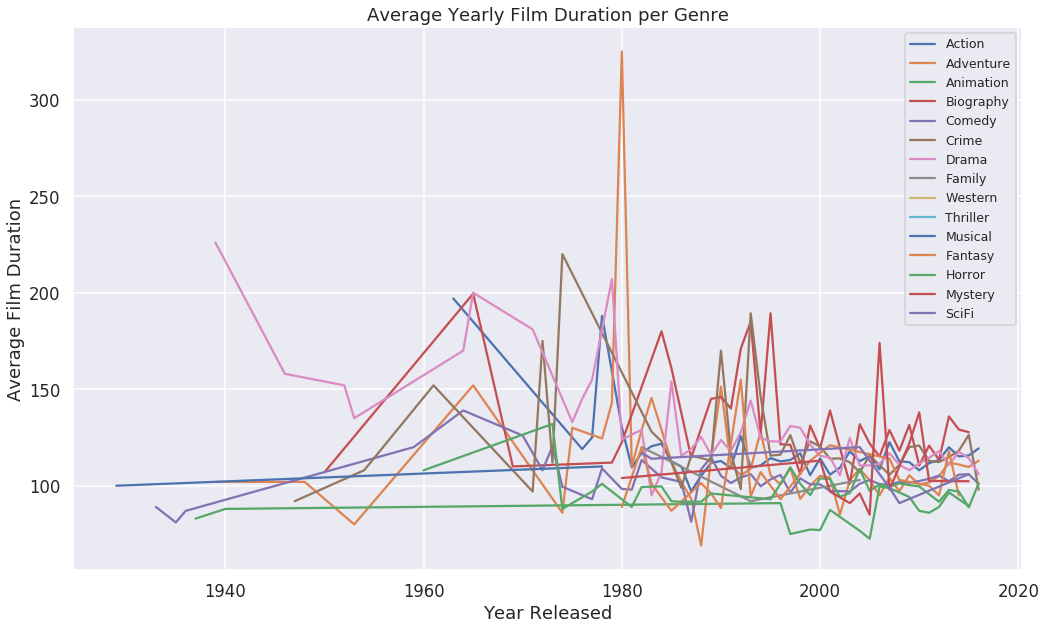

In [28]:
plt.figure(figsize=(17,10))
plt.plot(Action['title_year'],Action['duration'], label='Action')
plt.plot(Adventure['title_year'],Adventure['duration'], label='Adventure')
plt.plot(Animation['title_year'],Animation['duration'], label='Animation')
plt.plot(Biography['title_year'],Biography['duration'], label='Biography')
plt.plot(Comedy['title_year'],Comedy['duration'], label='Comedy')
plt.plot(Crime['title_year'],Crime['duration'], label='Crime')
plt.plot(Drama['title_year'],Drama['duration'], label='Drama')
plt.plot(Family['title_year'],Family['duration'], label='Family')
plt.plot(Western['title_year'],Western['duration'], label='Western')
plt.plot(Thriller['title_year'],Thriller['duration'], label='Thriller')
plt.plot(Musical['title_year'],Musical['duration'], label='Musical')
plt.plot(Fantasy['title_year'],Fantasy['duration'], label='Fantasy')
plt.plot(Horror['title_year'],Horror['duration'], label='Horror')
plt.plot(Mystery['title_year'],Mystery['duration'], label='Mystery')
plt.plot(SciFi['title_year'],SciFi['duration'], label='SciFi')
plt.legend(fontsize='x-small')
plt.title('Average Yearly Film Duration per Genre')
plt.xlabel('Year Released')
plt.ylabel('Average Film Duration')
plt.show()

#### Same line plot with only selected genres (one that appear to have fewer spikes/outliers)

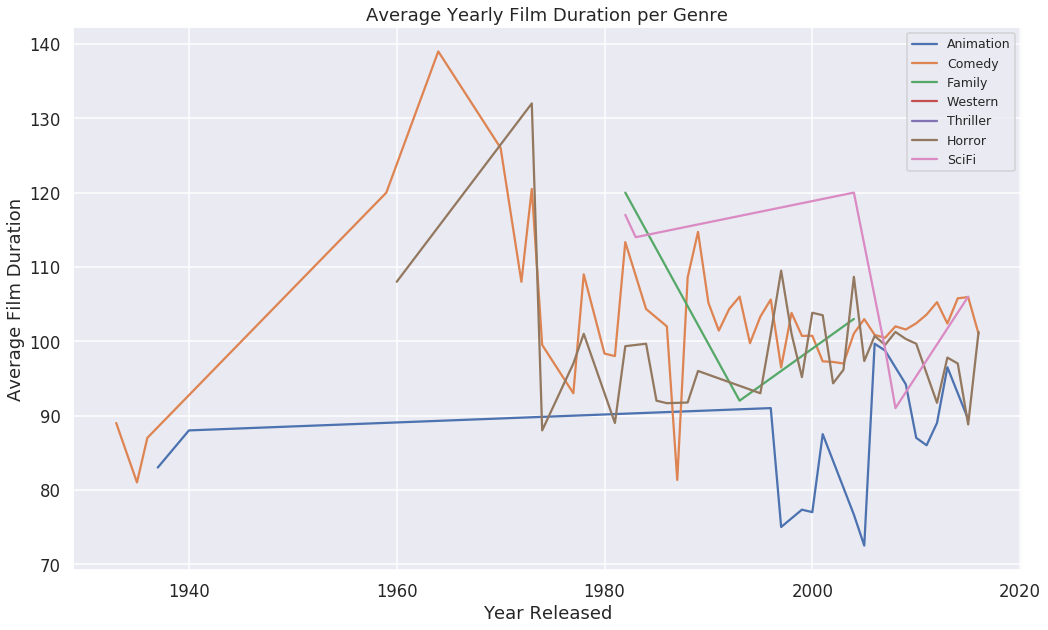

In [29]:
plt.figure(figsize=(17,10))
plt.plot(Animation['title_year'],Animation['duration'], label='Animation')
plt.plot(Comedy['title_year'],Comedy['duration'], label='Comedy')
plt.plot(Family['title_year'],Family['duration'], label='Family')
plt.plot(Western['title_year'],Western['duration'], label='Western')
plt.plot(Thriller['title_year'],Thriller['duration'], label='Thriller')
plt.plot(Horror['title_year'],Horror['duration'], label='Horror')
plt.plot(SciFi['title_year'],SciFi['duration'], label='SciFi')
plt.legend(fontsize='x-small')
plt.title('Average Yearly Film Duration per Genre')
plt.xlabel('Year Released')
plt.ylabel('Average Film Duration')
plt.show()

#### A line graph with the combined average yearly durations of the selected genres

Text(0, 0.5, 'Year Released')

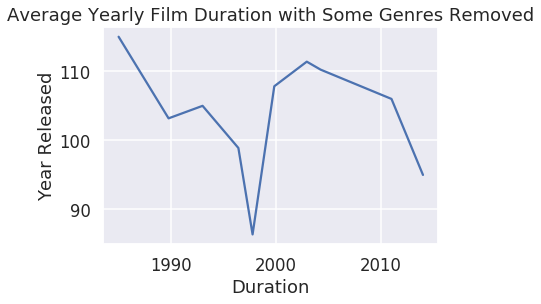

In [30]:
less_genres = genre_sort.where(
    genre_sort['genre']!='Action').where(
    genre_sort['genre']!='Adventure').where(
    genre_sort['genre']!='Biography').where(
    genre_sort['genre']!='Crime').where(
    genre_sort['genre']!='Drama').where(
    genre_sort['genre']!='Fantasy').where(
    genre_sort['genre']!='Musical').dropna()

avg_less_genres = less_genres.groupby('genre',as_index=False).mean().sort_values(by='title_year')
plt.plot(avg_less_genres['title_year'],avg_less_genres['duration'])
plt.title('Average Yearly Film Duration with Some Genres Removed')
plt.xlabel('Duration')
plt.ylabel('Year Released')

#### Counting films by their first listed genres

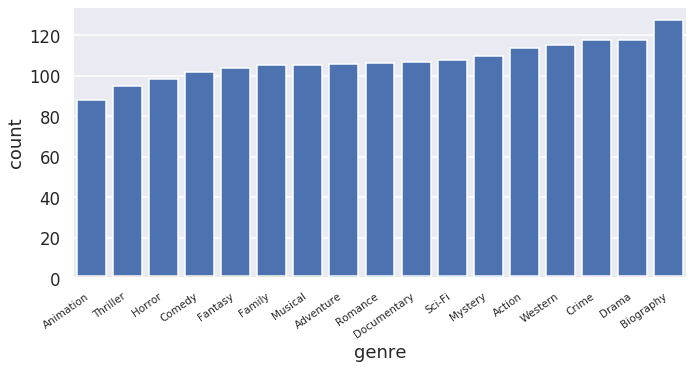

In [31]:
plt.figure(figsize=(11,5))
genre_total = movies[['genre', 'duration']].groupby('genre',as_index=False).mean().sort_values(by='duration')
plt.bar(genre_total['genre'],genre_total['duration'])
ax = sns.countplot(x='genre',data=genre_total).set_xticklabels(
    genre_total['genre'], rotation=35, ha="right", fontdict={'fontsize': 'xx-small'})

#### Interactive Scatterplot of Every Individual Genre's Film's Year vs Duration

In [32]:
fig = px.scatter(fivek_movies, x="title_year", y="duration", animation_frame="genre",
           size="duration", color="genre", hover_name="genre",
           log_x=True, size_max=55)

fig.show()

### Introducing Internet and Social Media Datasets

#### Data on the distribution of population subscribed each year

In [33]:
internet['% of Population Subscribed'].describe()

count    20.000000
mean     19.789520
std      11.838847
min       0.256185
25%       8.903367
50%      24.639034
75%      29.752785
max      33.852611
Name: % of Population Subscribed, dtype: float64

#### Graphing the types of technology and the percent of the population using these technologies yearly

Text(0, 0.5, 'Percent Subscribed')

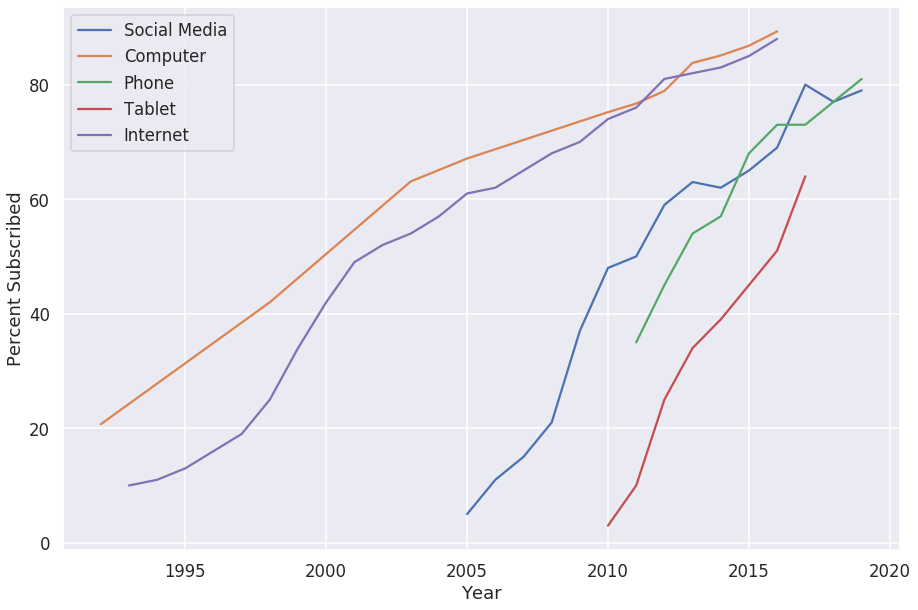

In [34]:
plt.figure(figsize=(15,10))
plt.plot(social["Year"], social['Percent Used'], label='Social Media')
plt.plot(computer["Year"], computer['Percent Used'], label='Computer')
plt.plot(phone["Year"], phone['Percent Used'], label='Phone')
plt.plot(tablet["Year"], tablet['Percent Used'], label='Tablet')
plt.plot(internet_use["Year"], internet_use['Percent Used'], label='Internet')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percent Subscribed')

#### Average film duration plotted next to the rise of internet usage.

Text(0.5, 0, 'Internet Usage')

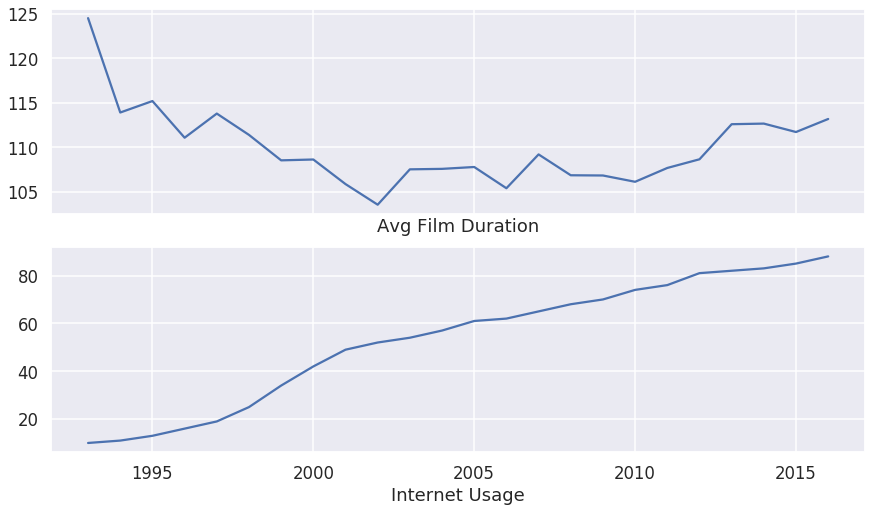

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True,figsize=(12,7))

ninty_now = year_and_len.where(year_and_len['title_year']>=min(internet_use['Year'].dropna())).dropna().groupby(year_and_len['title_year']).mean()
ax[0].plot(ninty_now['title_year'], ninty_now['duration'], label='Avg Film Duration')
ax[1].plot(internet_use["Year"], internet_use['Percent Used'], label='Internet Usage')

ax[0].set_xlabel('Avg Film Duration')
ax[1].set_xlabel('Internet Usage')

#### Using a standardize function to standardize Pandas Series data, to compare with other data features

In [36]:
def standardize(i):
    return (i - i.mean()) / i.std() 

#### Creating a standardized duration change column in the dataset

In [37]:
standardize = (fivek_movies['duration']-fivek_movies['duration'].mean())/fivek_movies['duration'].std()
fivek_movies['standard_duration'] = standardize
average = fivek_movies[['title_year','standard_duration']].groupby('title_year', as_index=False).mean()

#### Standardized Change in Internet Subscribtions vs Average Film Duration

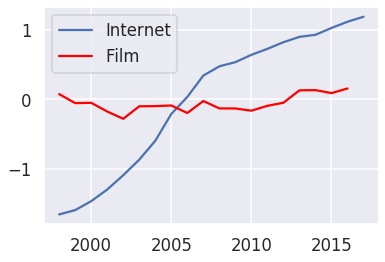

In [38]:
standard = (internet['% of Population Subscribed']-internet['% of Population Subscribed'].mean())/internet['% of Population Subscribed'].std()
internet['Standardized Data'] = standard
plt.plot(internet['Year'], internet['Standardized Data'], label='Internet')
avg = average.where(average['title_year']>=1998).dropna()
plt.plot(avg['title_year'], avg['standard_duration'],c='red', label='Film')
plt.legend()
plt.show()

### Step 3: Using Natural Language Tool Kit with Film Genres

In [39]:
import nltk
test_movies = fivek_movies

In [40]:
genres = [nltk.word_tokenize(i) for i in list([x.replace("|"," ") for x in fivek_movies['genres']])]
test_movies['genres']=genres

#### Hard coding every genre into individual columns

In [41]:
fivek_movies['genres']=genres
smaller_movie = fivek_movies.copy()[['title_year','movie_title','duration','genres','imdb_score']]
smaller_movie['Action']=[True in [(y in ['Action'])for y in x] for x in test_movies['genres']]
smaller_movie['Adventure']=[True in [(y in ['Adventure'])for y in x] for x in test_movies['genres']]
smaller_movie['Animation']=[True in [(y in ['Animation'])for y in x] for x in test_movies['genres']]
smaller_movie['Biography']=[True in [(y in ['Biography'])for y in x] for x in test_movies['genres']]
smaller_movie['Comedy']=[True in [(y in ['Comedy'])for y in x] for x in test_movies['genres']]
smaller_movie['Crime']=[True in [(y in ['Crime'])for y in x] for x in test_movies['genres']]
smaller_movie['Documentary']=[True in [(y in ['Documentary'])for y in x] for x in test_movies['genres']]
smaller_movie['Drama']=[True in [(y in ['Drama'])for y in x] for x in test_movies['genres']]
smaller_movie['Documentary']=[True in [(y in ['Documentary'])for y in x] for x in test_movies['genres']]
smaller_movie['Family']=[True in [(y in ['Family'])for y in x] for x in test_movies['genres']]
smaller_movie['Fantasy']=[True in [(y in ['Fantasy'])for y in x] for x in test_movies['genres']]
smaller_movie['Horror']=[True in [(y in ['Horror'])for y in x] for x in test_movies['genres']]
smaller_movie['Musical']=[True in [(y in ['Musical'])for y in x] for x in test_movies['genres']]
smaller_movie['Mystery']=[True in [(y in ['Mystery'])for y in x] for x in test_movies['genres']]
smaller_movie['Romance']=[True in [(y in ['Romance'])for y in x] for x in test_movies['genres']]
smaller_movie['Sci-Fi']=[True in [(y in ['Sci-Fi'])for y in x] for x in test_movies['genres']]
smaller_movie['Thriller']=[True in [(y in ['Thriller'])for y in x] for x in test_movies['genres']]
smaller_movie['Western']=[True in [(y in ['Western'])for y in x] for x in test_movies['genres']]

smaller_movie[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime','Drama','Family',
               'Fantasy','Horror','Musical','Mystery','Romance','Sci-Fi', 'Thriller','Western']] = smaller_movie[[
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime','Drama','Family',
               'Fantasy','Horror','Musical','Mystery','Romance','Sci-Fi', 'Thriller','Western']].apply(
    lambda x: (x==True).astype(int))

#### Plotting every data point of year released vs duration by genre

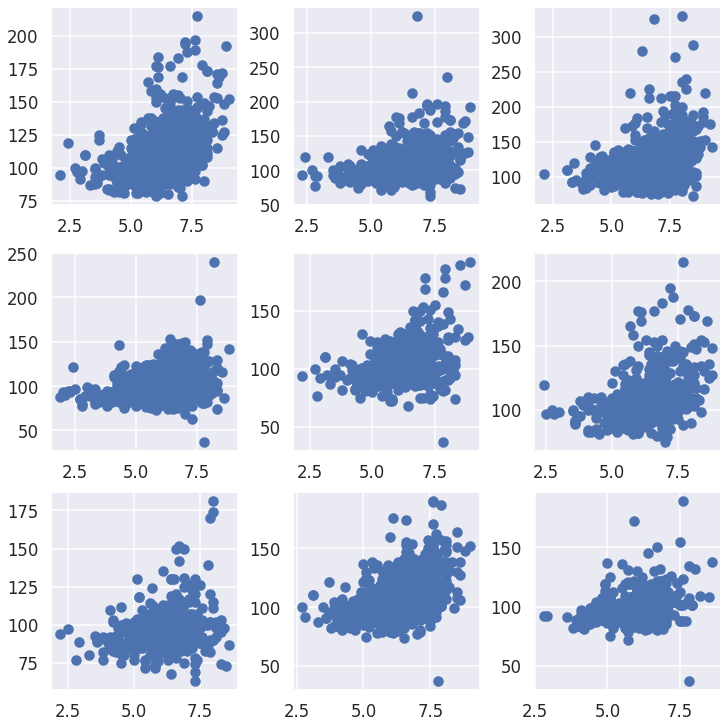

In [42]:
fig, ax = plt.subplots(3,3,constrained_layout=True,figsize=(10,10))

ax[0,0].scatter(smaller_movie.where(smaller_movie['Action']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Action']==1)['duration'])

ax[0,1].scatter(smaller_movie.where(smaller_movie['Adventure']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Adventure']==1)['duration'])

ax[1,0].scatter(smaller_movie.where(smaller_movie['Comedy']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Comedy']==1)['duration'])

ax[0,2].scatter(smaller_movie.where(smaller_movie['Drama']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Drama']==1)['duration'])

ax[2,0].scatter(smaller_movie.where(smaller_movie['Family']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Family']==1)['duration'])

ax[1,1].scatter(smaller_movie.where(smaller_movie['Fantasy']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Fantasy']==1)['duration'])

ax[2,2].scatter(smaller_movie.where(smaller_movie['Horror']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Horror']==1)['duration'])

ax[2,1].scatter(smaller_movie.where(smaller_movie['Thriller']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Thriller']==1)['duration'])

ax[1,2].scatter(smaller_movie.where(smaller_movie['Sci-Fi']==1)['imdb_score'],
            smaller_movie.where(smaller_movie['Sci-Fi']==1)['duration'])

### Step 4: Exploring other data features that may correlate to duration

#### A brief overview through scatter plots of duration vs other dataset variables (highlighted one is the most interesting)

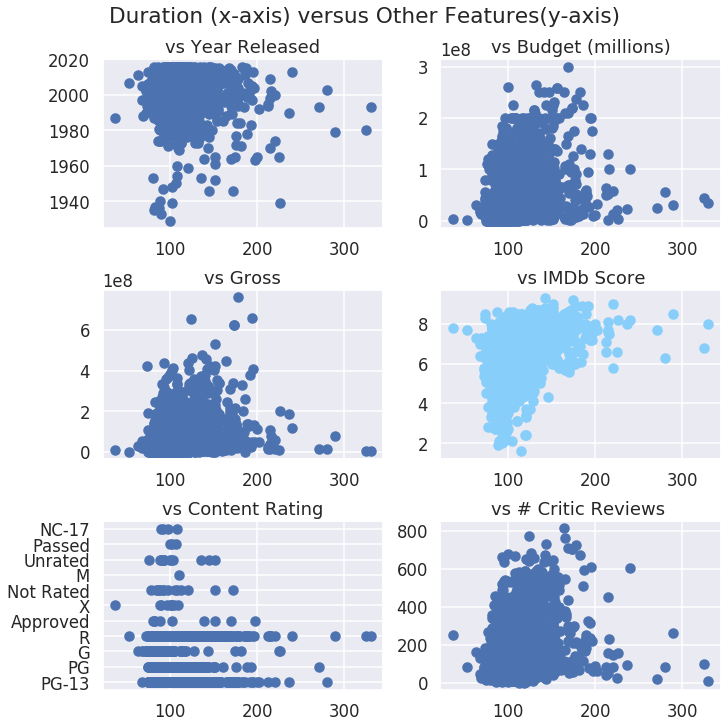

In [43]:
movie_specifics = movies[['duration', 'genres', 'movie_title', 'title_year', 'imdb_score']]
year_and_len = movie_specifics[['title_year','duration']]

fig, ax = plt.subplots(3,2,constrained_layout=True,figsize=(10,10))

ax[0,0].scatter(movies['duration'],movies['title_year'])
ax[0,0].set_title('vs Year Released')

ax[0,1].scatter(movies['duration'],movies['budget'])
ax[0,1].set_title('vs Budget (millions)')

ax[1,0].scatter(movies['duration'],movies['gross'])
ax[1,0].set_title('vs Gross')

ax[1,1].scatter(movies['duration'],movies['imdb_score'],color='lightskyblue')
ax[1,1].set_title('vs IMDb Score')

ax[2,0].scatter(movies['duration'],movies['content_rating'])
ax[2,0].set_title('vs Content Rating')

ax[2,1].scatter(movies['duration'],movies['num_critic_for_reviews'])
ax[2,1].set_title('vs # Critic Reviews ')

fig.suptitle('Duration (x-axis) versus Other Features(y-axis)')
fig.show()

#### Looking at the correlation between duration and other dataset variables

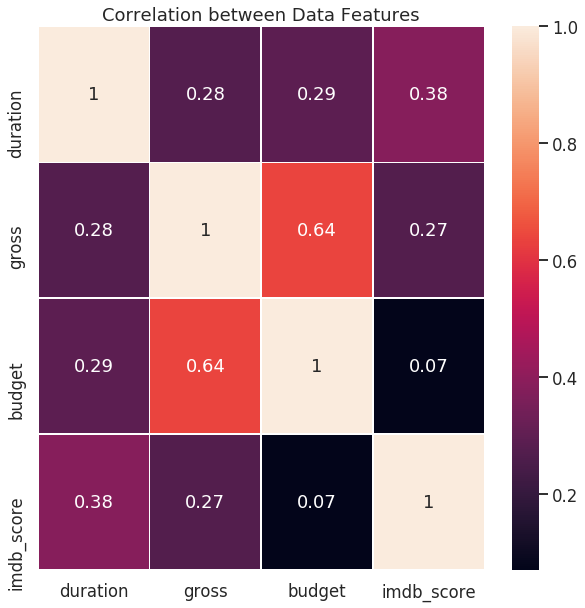

In [44]:
basic_movies = fivek_movies[['duration','gross','genres','budget','imdb_score']]
basic_movies.corr()
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(basic_movies.corr(),annot=True, linewidths=.5, ax=ax)
plt.title('Correlation between Data Features')
plt.show()

#### Gross has a decent correlation to duration, and with budget as another financial factor, a 3d plot exploring this relationship

In [45]:
fig = go.Figure()
movies = fivek_movies
data_scatter = go.Scatter3d(x=fivek_movies["budget"], y=fivek_movies["gross"], z=fivek_movies["duration"], 
                            mode="markers",
                            marker=dict(size=2,color='blue',colorscale='Viridis'))
fig.add_trace(data_scatter)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)
fig

#### Shortening the internet_usage dataset slightly so the years line up with the film dataset (which caps at 2017)

In [46]:
internet_usage = internet_use.where(internet_use['Year']>1997).dropna().where(internet_use['Year']<=2017).dropna()

#### Adding extra years to the social media data so the years line up with the internet dataset's (social media is younger than the internet)

In [47]:
social = social.drop(['Tech'],axis=1)
social = social.where(social['Year']<2017).dropna()
social = social.append({'Year':2004,'Percent Used':0},ignore_index=True)
social = social.append({'Year':2003,'Percent Used':0},ignore_index=True)
social = social.append({'Year':2002,'Percent Used':0},ignore_index=True)
social = social.append({'Year':2001,'Percent Used':0},ignore_index=True)
social = social.append({'Year':2000,'Percent Used':0},ignore_index=True)
social = social.append({'Year':1999,'Percent Used':0},ignore_index=True)
social = social.append({'Year':1998,'Percent Used':0},ignore_index=True)
social = social.sort_values(by=['Year'])

#### Grouping the films by year released from 1998 onward and finding the average film duration per year

In [48]:
film_grouped_yearly = fivek_movies.where(fivek_movies['title_year']>=1998).dropna().groupby('title_year',as_index=False).mean()
film_grouped_yearly['internet_subscriptions']=pd.Series(internet['% of Population Subscribed'])

#### Creating a new DataFrame with standardized internet, social media, and film duration columns

In [57]:
netfilm = pd.DataFrame(film_grouped_yearly[['title_year','duration','gross','budget','imdb_score',
                               'standard_duration','internet_subscriptions']])
netfilm['social_media']=list(pd.Series(social['Percent Used']))
netfilm['internet_percent']=list(pd.Series(internet_usage['Percent Used']))

#### Interactive scatter plot of year released and duration by genre (first listed genre) 

In [58]:
fig = px.scatter(fivek_movies, x="title_year", y="duration", animation_frame="genre",
           size="duration", color="genre", hover_name="genre",
           log_x=True, size_max=55)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

#### 3d scatter plot of percentage of US population with internet subscriptions vs social media usage vs standard change in film duration 

In [59]:
fig = go.Figure()
movies = fivek_movies
data_scatter = go.Scatter3d(x=netfilm["internet_percent"], y=netfilm["social_media"], z=netfilm["standard_duration"], 
                            mode="markers",
                            marker=dict(size=10,color='blue',colorscale='Viridis'))
fig.add_trace(data_scatter)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)
fig

#### Correlation between dataset variables, this time including standardized change in film duration, internet, and social media usage

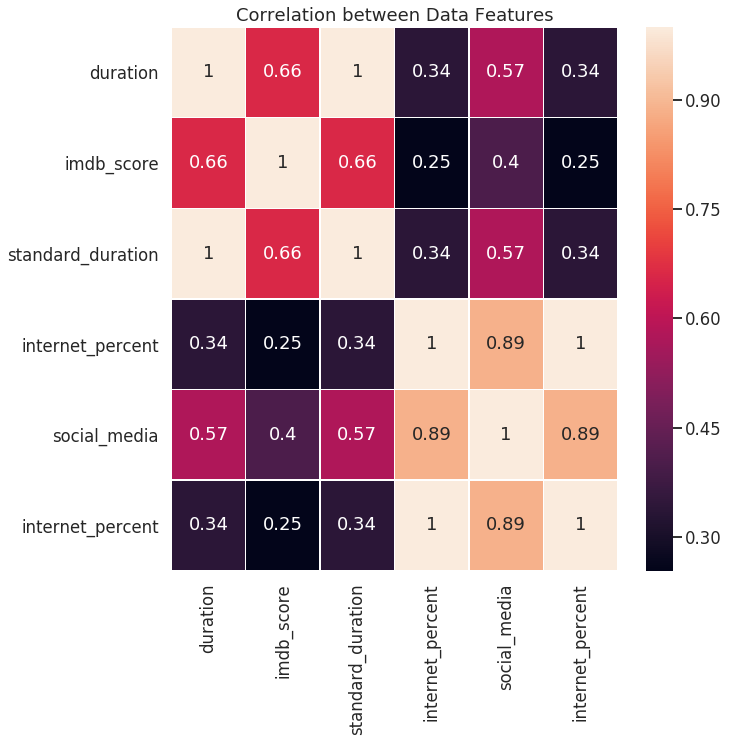

In [64]:
f,ax=plt.subplots(figsize=(10,10))
standardized_df = netfilm[['duration','imdb_score','standard_duration','internet_percent',
                           'social_media', 'internet_percent']]
sns.heatmap(standardized_df.corr(),annot=True, linewidths=.5, ax=ax)
plt.title('Correlation between Data Features')
plt.show()

## Step 5: Linear Regression Analysis

### Looking to find a connection between duration and budget / gross

#### Beginning with creating a Linear Regression Model

In [65]:
model = LinearRegression(fit_intercept=True)
model.fit(movies[["budget", "gross"]], movies[["duration"]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Creating a plot plane to visualize the Linear Regression (function originally by Data Science 100)

In [66]:
def plot_plane(f, X, grid_points = 30):
    u = np.linspace(X[:,0].min(),X[:,0].max(), grid_points)
    v = np.linspace(X[:,1].min(),X[:,1].max(), grid_points)
    xu, xv = np.meshgrid(u,v)
    X = np.vstack((xu.flatten(),xv.flatten())).transpose()
    z = f(X)
    return go.Surface(x=xu, y=xv, z=z.reshape(xu.shape),opacity=0.8)

#### Assigning features to X and Y, to predict Y using the model

In [67]:
X = movies[["budget", "gross"]].values
Y = movies[["duration"]].values

#### Predicting the film durations through the model, then graphing these predictions along with the actual data

In [68]:
movies['Y_hat'] = model.predict(movies[["budget", "gross"]])
fig = go.Figure()
fig.add_trace(data_scatter)
fig.add_trace(plot_plane(model.predict, X))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)

#### This plane doesn't seem to capture most of the data points, so I'll look into other variables to test

In [69]:
Y = movies['duration']
X_features = movies[['budget', 'gross']]

#### Defining some functions to calculate error (via Data 100)

In [71]:
def avg_squared_loss(y, y_hat):
    return np.mean((y - y_hat)**2)
def linear_model(theta, X): 
    return X @ theta

#### Calculating the items to find error

In [72]:
theta = np.array([1,1])
Y_hat = linear_model(theta, X)
loss = avg_squared_loss(Y, Y_hat)

#### Creating a new model

In [73]:
model = LinearRegression()
model.fit(X, Y)
Y_hat = model.predict(X)
loss = avg_squared_loss(Y, Y_hat)
loss

441.63916919235527

#### Assigning data to train and test sets

In [75]:
train_documents, test_documents = train_test_split(movies[['imdb_score','budget','duration']], 
                                                   test_size=0.1, random_state=83)
X_train = train_documents[['budget','imdb_score']]
Y_train = pd.Series(train_documents['duration'])
X_test = test_documents[['budget','imdb_score']]
Y_test = pd.Series(test_documents['duration'])

#### Graph of model for duration vs predicted

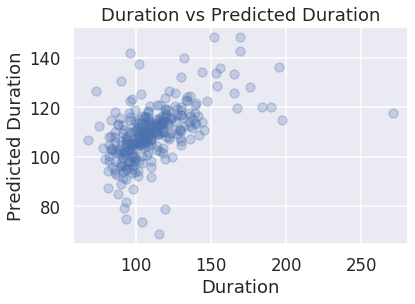

In [76]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

# Fit your linear model
linear_model.fit(X_train, Y_train)

# Predict housing prices on the test set
Y_pred = linear_model.predict(X_test)

# Plot predicted vs true prices
plt.scatter(Y_test, Y_pred, alpha=0.25)
plt.xlabel("Duration")
plt.ylabel("Predicted Duration")
plt.title("Duration vs Predicted Duration");

#### Root mean squared error of the function (via Data 100)

In [77]:
def rmse(actual_y, predicted_y):
    return ((sum((actual_y - predicted_y)**2))/len(actual_y))**(1/2)

train_error = rmse(Y_train, linear_model.predict(X_train))
test_error = rmse(Y_test,Y_pred)

print("Training RMSE:", train_error)
print("Test RMSE:", test_error)

Training RMSE: 19.588754058887076
Test RMSE: 19.374059713495956


#### Finding Error

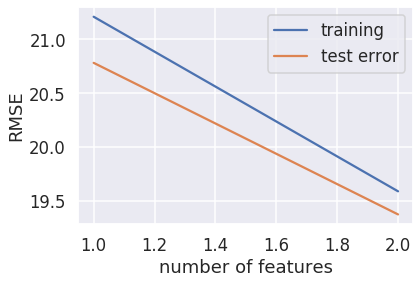

In [78]:
train_error_vs_N = []
test_error_vs_N = []

range_of_num_features = range(1, X_train.shape[1] + 1)

for N in range_of_num_features:
    X_train_first_N_features = X_train.iloc[:, :N]    
    
    linear_model.fit(X_train_first_N_features, Y_train)
    train_error = rmse(Y_train, linear_model.predict(X_train_first_N_features))
    train_error_vs_N.append(train_error)
    
    X_test_first_N_features = X_test.iloc[:, :N]
    test_error = rmse(Y_test, linear_model.predict(X_test_first_N_features))    
    test_error_vs_N.append(test_error)
    
plt.plot(range_of_num_features, train_error_vs_N)
plt.plot(range_of_num_features, test_error_vs_N)
plt.legend(["training", "test error"])
plt.xlabel("number of features")
plt.ylabel("RMSE");

#### Linear model on IMDb Score vs duration

In [82]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
loss = avg_squared_loss(Y_test, Y_hat)
loss

375.354189782107

#### Plotting error and model

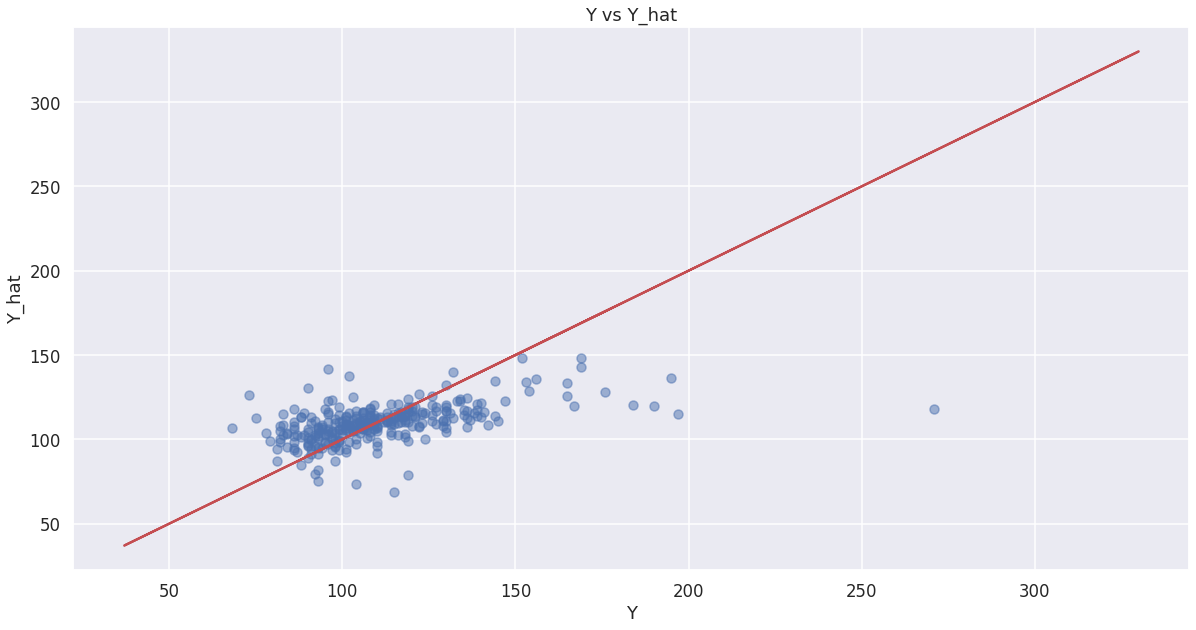

In [88]:
Y_s = [1 for _ in range(len(Y))] # setting the sizes of the markers to 1
plt.figure(figsize = (20, 10))
plt.scatter(Y_test, Y_hat,alpha=.5)
plt.plot(Y, Y, c = 'r') # the identity line
plt.xlabel('Y')
plt.ylabel('Y_hat')
plt.title('Y vs Y_hat')
plt.show()

#### Duration vs Predicted duration scatter plot

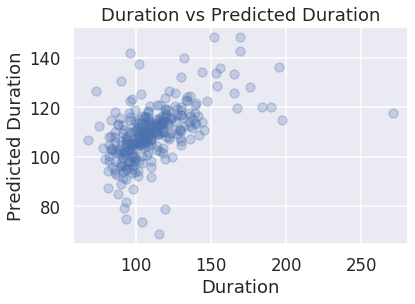

In [90]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

# Fit your linear model
linear_model.fit(X_train, Y_train)

# Predict housing prices on the test set
Y_pred = linear_model.predict(X_test)

# Plot predicted vs true prices
plt.scatter(Y_test, Y_pred, alpha=0.25)
plt.xlabel("Duration")
plt.ylabel("Predicted Duration")
plt.title("Duration vs Predicted Duration");

#### Error for the given model

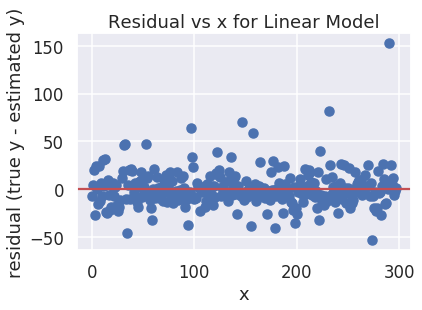

In [91]:
plt.scatter(np.arange(len(X_test)), Y_test - linear_model.predict(X_test))
plt.xlabel('x')
plt.ylabel('residual (true y - estimated y)')
plt.title('Residual vs x for Linear Model')
plt.axhline(y = 0, color='r');

### Exploring IMDb score correlation with duration

#### Randomly assigning rows of data to the training set and test set for the linear model

In [107]:
netfilm = pd.DataFrame(film_grouped_yearly[['title_year','duration','gross','budget','imdb_score',
                               'standard_duration','internet_subscriptions']])
netfilm['social_media']=list(pd.Series(social['Percent Used']))
netfilm['internet_percent']=list(pd.Series(internet_usage['Percent Used']))

np.random.seed(1337)
shuffled_indices = np.random.permutation(len(netfilm))

#### Assigning 80% of shuffled_indices to the training set, and the other 20% to the test indicies

In [108]:
train_indices = shuffled_indices[:15]
test_indices = shuffled_indices[15:]
train = netfilm.loc[train_indices]
test = netfilm.loc[test_indices]

#### Assigning train and test data to X and Y variables

In [109]:
X_train = train[['imdb_score']]
y_train = train['duration']
X_test=test[['imdb_score']]
y_test = test['duration']

#### Creating the linear model

In [110]:
linear_model = lm.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

#### Fitting the linear model to the data

In [111]:
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

#### Creating a function for calculating the root mean square error of a predicted value and an actual value

In [112]:
def rmse(actual, predicted):
    return (((sum((actual - predicted)**2))/len(actual))**(1/2))

#### Applying the function to the training and test data

In [113]:
training_error = rmse(y_train, y_fitted)
test_error = rmse(y_test,y_predicted)
(training_error, test_error)

(1.9891333845994195, 1.8990792061083122)

#### Calculating and plotting the residuals (error) of the model

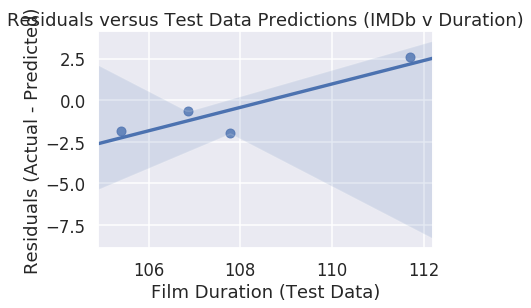

In [114]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Film Duration (Test Data)')
ax.set_ylabel('Residuals (Actual - Predicted)')
ax.set_title("Residuals versus Test Data Predictions (IMDb v Duration)");

#### As you can see, the error is very close to the graphed line, meaning this is a rather decent model

## Step 6: Final Visualizations and Conclusions

#### A visualization of the IMDb score vs the duration of films of a given year

In [115]:
fig = px.scatter(fivek_movies, x="duration", y="imdb_score", animation_frame="title_year",
           size="duration", color="genre", hover_name="genre",
           log_x=True, size_max=55)

fig.show()

#### Another visualization, this time showing the title_year vs duration for all films of a given IMDB score

In [ ]:
fig = px.scatter(fivek_movies, x="title_year", y="duration", animation_frame="imdb_score",
           size="imdb_score", color="genre", hover_name="genre",
           log_x=True, size_max=15)

fig.show()

#### Line graph of the average film length per IMDb score

In [ ]:
scores = movies[['imdb_score','duration']].groupby(movies['imdb_score']).mean()
plt.scatter(scores['imdb_score'],scores['duration'])
plt.plot(scores['imdb_score'],scores['duration'],color='black')
plt.xlabel('IMDb Score')
plt.ylabel('Film Duration')
plt.title('IMDb Score vs Duration')
plt.show()

### 3d Visualization of Year Released vs IMDb Score vs Duration

In [ ]:
fig = go.Figure()
movies = fivek_movies
data_scatter = go.Scatter3d(x=fivek_movies["title_year"], y=fivek_movies["imdb_score"], z=fivek_movies["duration"], 
                            mode="markers",
                            marker=dict(size=5,color='blue',colorscale='Viridis'))
fig.add_trace(data_scatter)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)
fig